In [20]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.morphology import (erosion, dilation, closing, opening,
                                area_closing, area_opening)
from skimage.measure import label, regionprops, regionprops_table
import pandas as pd

Image Read and Denoise

In [2]:
def read_image(path):
    image = imread(path)
    if len(image.shape) > 2:
        return rgb2gray(image)
    return image

def bilateral_filter(image, diameter=15, sigma_color=75, sigma_space=75):
    print(image.max())
    if image.max() != 255:
        image = image * 255
        image = image.astype('uint8')
        return cv2.bilateralFilter(image, diameter, sigma_color, sigma_space) / 255
    return cv2.bilateralFilter(image, diameter, sigma_color, sigma_space)

def median_filter(image, kernel_size=3):
    if image.max() != 255:
        image = image * 255
        image = image.astype('uint8')
        return cv2.medianBlur(image, kernel_size) / 255
    return cv2.medianBlur(image, kernel_size)


def non_local_mean_filter(image, h=3):
    if image.max() != 255:
        image = image * 255
        image = image.astype('uint8')
        return cv2.fastNlMeansDenoising(image, h=h) / 255
    return cv2.fastNlMeansDenoising(image, h=h)

## Image thresholding and connected components

In [8]:
image_path = "../Data/test_images/msg_from_annie.png"
image = read_image(image_path)
# filtered_image = bilateral_filter(image)
# filtered_image_2 = non_local_mean_filter(image)
filtered_image = median_filter(image)

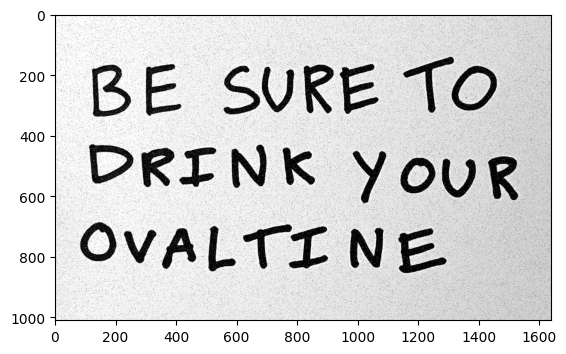

In [9]:
plt.imshow(image, cmap="gray")

In [10]:
# plt.imshow(filtered_image_3, cmap="gray")
# plt.imshow(filtered_image_2, cmap="gray")

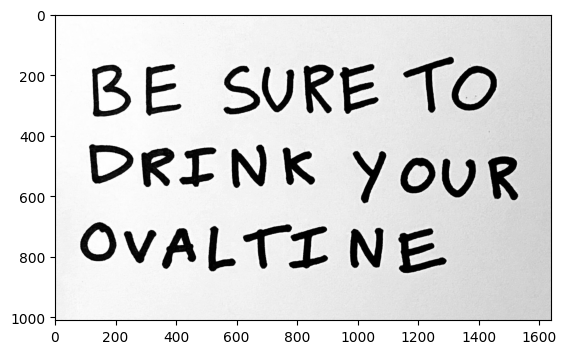

In [7]:
plt.imshow(filtered_image, cmap="gray")

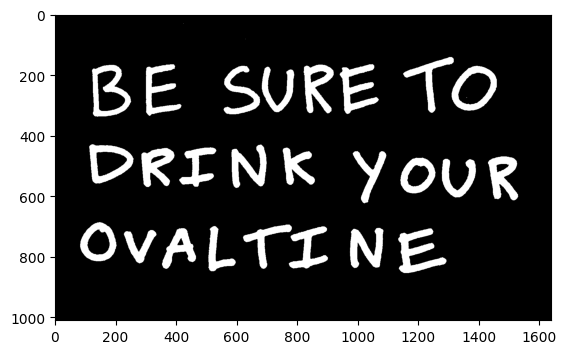

In [11]:
binarized_image = filtered_image < 0.55
plt.imshow(binarized_image, cmap="gray")

## Erosion, Dilation

In [13]:
square = np.array([[1,1,1],
                   [1,1,1],
                   [1,1,1]])
                   
def multi_dil(im, num, element=square):
    for i in range(num):
        im = dilation(im, element)
    return im
def multi_ero(im, num, element=square):
    for i in range(num):
        im = erosion(im, element)
    return im

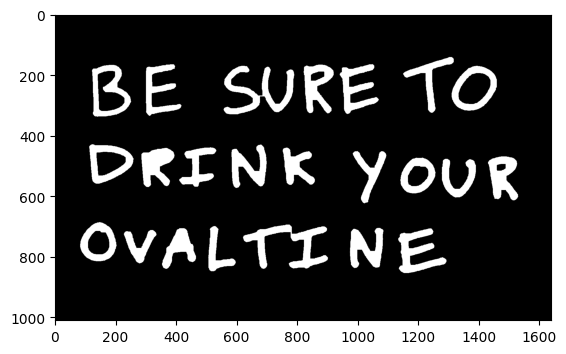

In [16]:
multi_dilated = multi_dil(binarized_image, 7)
area_closed = area_closing(multi_dilated, 5)
multi_eroded = multi_ero(area_closed, 7)
opened_image = opening(multi_eroded)
plt.imshow(opened_image, cmap="gray")

## Connected components

30


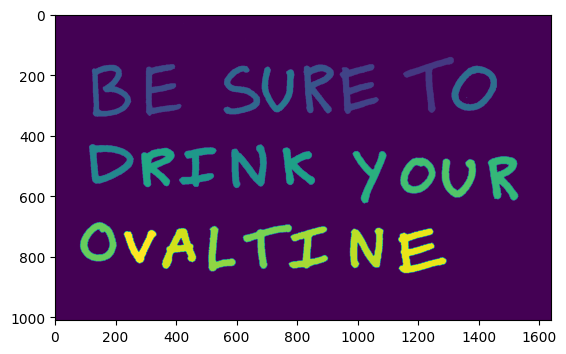

In [43]:
label_im = label(binarized_image)
regions = regionprops(label_im)
print(len(regions))
plt.imshow(label_im)

In [38]:
properties = ['area','convex_area','bbox_area', 'extent',  
              'mean_intensity', 'solidity', 'eccentricity', 
              'orientation', 'centroid']
pd.DataFrame(regionprops_table(label_im, filtered_image, 
             properties=properties))

,area,convex_area,bbox_area,extent,mean_intensity,solidity,eccentricity,orientation,centroid-0,centroid-1
0,1,1,1,1.000000,0.278431,1.000000,0.000000,0.785398,0.000000,324.000000
1,1,1,1,1.000000,0.274510,1.000000,0.000000,0.785398,1.000000,783.000000
2,1,1,1,1.000000,0.278431,1.000000,0.000000,0.785398,31.000000,423.000000
3,1,1,1,1.000000,0.274510,1.000000,0.000000,0.785398,82.000000,628.000000
4,6646,15974,30728,0.216285,0.028619,0.416051,0.728422,-0.180632,211.334487,1234.287692
5,8625,16535,21285,0.405215,0.033026,0.521621,0.716610,-0.034937,244.392580,992.109101
6,7841,16850,20060,0.390877,0.063337,0.465341,0.797316,0.021755,250.521235,340.267951
7,8346,14319,15939,0.523621,0.033951,0.582862,0.823930,-0.043849,238.270549,862.075725
8,9234,18049,22059,0.418605,0.071622,0.511607,0.716190,0.089703,253.590427,177.024150
9,6687,15036,19200,0.348281,0.047092,0.444733,0.780163,0.240204,258.667414,612.020188


In [31]:
masks = []
bbox = []
list_of_index = []
for num, x in enumerate(regions):
    area = x.area
    convex_area = x.convex_area
    # print(num, area, convex_area)
    if num!=0 and area>100 and area/convex_area <1.00: # and (convex_area/area >0.95)):
        masks.append(regions[num].convex_image)
        bbox.append(regions[num].bbox)   
        list_of_index.append(num)
count = len(masks)
print(count)

25


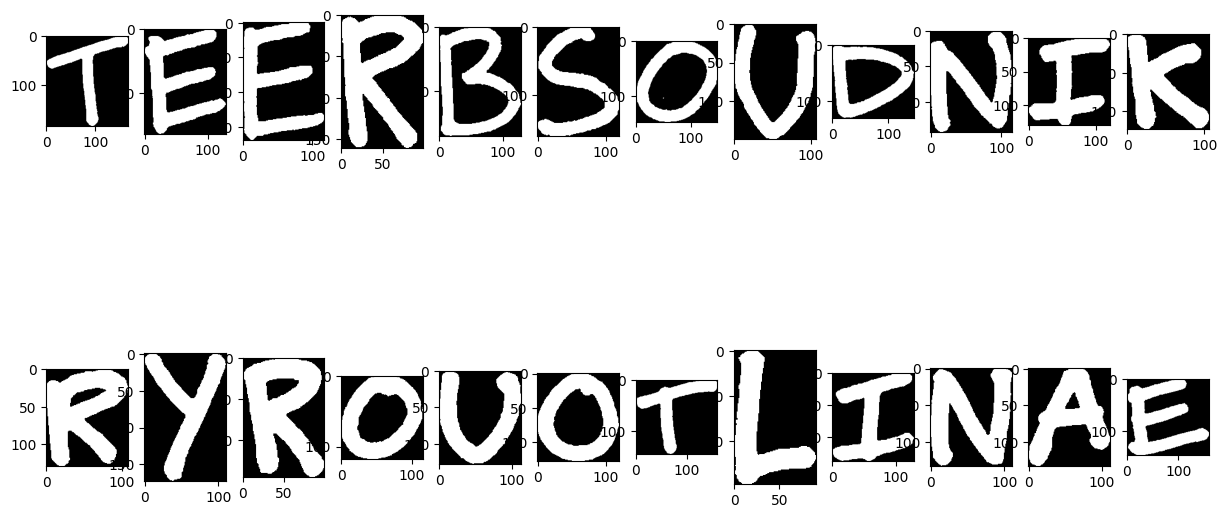

In [48]:
fig, ax = plt.subplots(2, int(count/2), figsize=(15,8))
bounded_images = []
for axis, box, mask in zip(ax.flatten(), bbox, masks):
    bounded_image  =  binarized_image[box[0]:box[2], box[1]:box[3]] * mask
    # bounded_image = np.resize(bounded_image, (28, 28))
    bounded_images.append(bounded_image)
    axis.imshow(bounded_image, cmap="gray")


## Model Predict

In [45]:
from predict import CharacterPredictor

predictor = CharacterPredictor(model_path="../Data/model.pth")

for bounded_image in bounded_images:
    prep_image = np.resize(bounded_image, (28, 28))
    print(predictor.predict(prep_image))

E
Z
A
B
Z
Z
Z
Z
Z
Z
A
B
Z
Z
A
Z
E
Z
Z
B
Z
Z
Z
Z
